In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras import models
from keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import rgb_to_grayscale
from tensorflow import reshape
from tensorflow.image import resize_with_pad
import matplotlib.pyplot as plt 
import os
import numpy as np
%matplotlib inline

## Importing Data

In [5]:
def import_image(PATH, image_name):
    """
    PATH --> str: Relative path to image directoy
    image_name --> str: Name of the image to load
    
    Returns:
    PIL image
    
    """
    
    # create path to file
    img_path = PATH + "/" + image_name
    
    # load file and return pil
    return image.load_img(img_path) 

In [56]:
def grayscale_and_resize(PIL, shape=(255,256), padding=False):
    """
    This is the preprocessing function that will take the raw jpeg, gray scale it, resize it and 
    turn it into an array
    
    
    PIL --> PIL object
    shape --> tuple: size of the final array
    padding --> bool: if True, will use tf.resize_with_pad
    """
    if padding:
        gray_image = rgb_to_grayscale(PIL)
        resized_image_arr = resize_with_pad(gray_image, target_height=shape[0], target_width=shape[1])
    else:
        resized_image_arr = img_to_array(PIL.convert(mode = 'L').resize(shape))
    
    return resized_image_arr


def import_image_to_array(RELPATH,
         dir_names = ['train', 'test', 'val'],
         sub_dir_names = ['NORMAL', 'PNEUMONIA'],
         padding=False,
         shape=(256,256), test=False):
    """
    This function loads all train, test and validation data into a dictionary of images
    =====================================================================================
    RELPATH --> str: The relative path to the cwd to the directory containing image directories
    eg '../../src/data/chest_xray'
    =====================================================================================
    dir_names --> list, str: The names of the subdirectories containing the images
    eg ['train', 'test', 'val'] <-- default
    =====================================================================================
    sub_dir_names --> list -> str: names of the subdirectory containg postivie and negative cases
    
    =====================================================================================
    padding  --> bool: Whether you want the reshaping to be padded to or not
    
    =====================================================================================
    shape --> tuple-> int: The final shape of the tensor array
    
    returns
    
    dict --> str:list -> tuple -> (tf.array, bool)
    A dictionary where the keys are the dir_names and the values are lists containing tuple where 
    the first index is the tf.array and the second is a boolian, True if class is pnuemonia, false otherwise.
    """
    # test relative path works!! 
    PATH = os.getcwd() + RELPATH
    
    try:
        os.listdir(PATH)
        print("You're relative directory is good, proceeding to import files...", end="\n\n")
    except Exception as e:
        print(str(e))
        print(f"Your relative path directory is not pointing to the correct location. Double check your input \n")
        print("Terminating Program", end='\n')
        print("=======================================================================================")
        return False
    # instantiate a dict object and populate the keys
    image_dict = {}
    for name in dir_names:
        image_dict[name] = []
        
        print(f"Loading images from {name}", end='\n')
        
        
        # For each subdirectory, get all of the images and append to dictionary
        for sub_dir in sub_dir_names:
            subPATH = PATH + name + "/" + sub_dir
            # list of all image names in the subdirectory
            image_batch = os.listdir(subPATH)
            
            for image in image_batch:
                # import the image in pil format
                pil = import_image(subPATH, image)
                # gray scale and reshape the image turning it into an array
                gray_resized_pil = grayscale_and_resize(pil, shape=shape, padding=padding)
                
                # center the pixels
                centered_array = gray_resized_pil/255
                
                # append to the image_dict
                flag = 1
                if sub_dir == 'NORMAL':
                    flag = 0
                
                image_dict[name].append((centered_array, flag))
                
            
                # if this is just a test case, break out of this loop so we get one from each class
                if test == True:
                    break
            
            print(f"Finished loading images from {sub_dir}", end="\n")

        print()
    
    return image_dict               

In [57]:
images = import_image_to_array('/chest_xray/',
         dir_names = ['train', 'test', 'val'],
         sub_dir_names = ['NORMAL', 'PNEUMONIA'],
         padding=False,
         shape=(256,256), test=False)

You're relative directory is good, proceeding to import files...

Loading images from train
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from test
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from val
Finished loading images from NORMAL
Finished loading images from PNEUMONIA



In [68]:
#list comprehensions to split the imported data into train/test/val 
X_train = np.array([i[0] for i in images['train']])  
y_train = np.array([i[1] for i in images['train']])

X_test = np.array([i[0] for i in images['test']])
y_test = np.array([i[1] for i in images['test']])

X_val = np.array([i[0] for i in images['val']])
y_val = np.array([i[1] for i in images['val']])

## Modeling

In [69]:
#baseline model- two convolution layers, maxpooling, one 32 node dense layer and the output

cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [70]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_val, y_val))

Epoch 1/5
105/105 [==============================] - 214s 2s/step - loss: 0.4960 - acc: 0.7749 - val_loss: 0.5299 - val_acc: 0.8125
Epoch 2/5
105/105 [==============================] - 190s 2s/step - loss: 0.3079 - acc: 0.8775 - val_loss: 0.9982 - val_acc: 0.6250
Epoch 3/5
105/105 [==============================] - 199s 2s/step - loss: 0.2106 - acc: 0.9181 - val_loss: 0.7651 - val_acc: 0.5625
Epoch 4/5
105/105 [==============================] - 199s 2s/step - loss: 0.1800 - acc: 0.9346 - val_loss: 0.3735 - val_acc: 0.8750
Epoch 5/5
105/105 [==============================] - 199s 2s/step - loss: 0.1694 - acc: 0.9342 - val_loss: 0.3962 - val_acc: 0.8125


In [72]:
results_test = cnn.evaluate(X_test, y_test)

20/20 [==============================] - 6s 307ms/step - loss: 0.5075 - acc: 0.7885


In [73]:
results_train = cnn.evaluate(X_train, y_train)

163/163 [==============================] - 58s 358ms/step - loss: 0.1549 - acc: 0.9484


Not bad right out of the box. We borrowed some code from lecture to visualize our loss and accuracy.

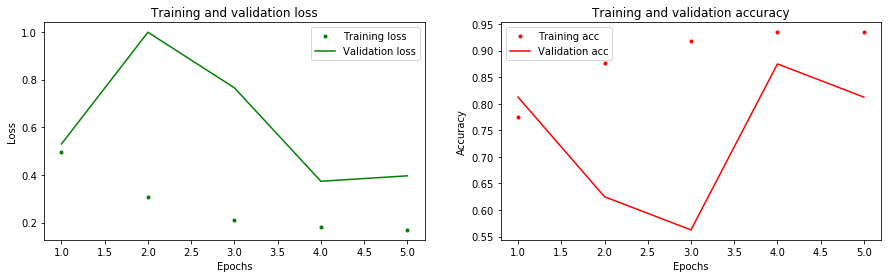

In [74]:
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Adding weights and dropouts, changing optimizers

In [96]:
# calculate inverse 
pnue_frequency = sum(y_train)/len(y_train)
inv_pnue_frequency = 1/pnue_frequency
normal_frequency = (len(y_train)-sum(y_train))/len(y_train)
inv_normal_frequency = 1/normal_frequency
weights = {
    0: inv_normal_frequency,
    1: inv_pnue_frequency
}

In [92]:
from tensorflow.keras.optimizers import Adam
Adam = Adam()

For the second model we added dropout layers and two extra dense layers. We also changed our optimizer to Adam and our pooling to average. Finally, we added class weights.

In [98]:
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn2.add(layers.AveragePooling2D((2, 2)))
cnn2.add(layers.Dropout(.2))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.AveragePooling2D((2, 2)))
cnn2.add(layers.Dropout(.2))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dropout(.2))
cnn2.add(layers.Dense(16, activation = 'relu'))
cnn2.add(layers.Dropout(.1))
cnn2.add(layers.Dense(32, activation = 'relu'))
cnn2.add(layers.Dense(1, activation='sigmoid'))

cnn2.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['acc'])

In [99]:
cnn3 = cnn2.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_test, y_test), class_weight = weights)

Epoch 1/5
105/105 [==============================] - 214s 2s/step - loss: 0.8503 - acc: 0.7841 - val_loss: 0.3640 - val_acc: 0.8205
Epoch 2/5
105/105 [==============================] - 211s 2s/step - loss: 0.4161 - acc: 0.9241 - val_loss: 0.5542 - val_acc: 0.7580
Epoch 3/5
105/105 [==============================] - 205s 2s/step - loss: 0.2905 - acc: 0.9490 - val_loss: 0.6729 - val_acc: 0.7644
Epoch 4/5
105/105 [==============================] - 212s 2s/step - loss: 0.2919 - acc: 0.9494 - val_loss: 0.4953 - val_acc: 0.7981
Epoch 5/5
105/105 [==============================] - 209s 2s/step - loss: 0.2717 - acc: 0.9463 - val_loss: 0.7077 - val_acc: 0.7724


In [100]:
results_test = cnn2.evaluate(X_val, y_val)

1/1 [==============================] - 0s 1ms/step - loss: 0.2258 - acc: 0.8750


A substantial improvement to the validation set but our test numbers leave a little to be desired. For the next run, back to max pooling.

In [108]:
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn4.add(layers.MaxPooling2D((2, 2)))
cnn4.add(layers.Dropout(.2))
cnn4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D((2, 2)))
cnn4.add(layers.Dropout(.2))
cnn4.add(layers.Flatten())
cnn4.add(layers.Dense(32, activation='relu'))
cnn4.add(layers.Dropout(.2))
cnn4.add(layers.Dense(16, activation = 'relu'))
cnn4.add(layers.Dropout(.1))
cnn4.add(layers.Dense(32, activation = 'relu'))
cnn4.add(layers.Dense(1, activation='sigmoid'))

cnn4.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['acc'])

In [109]:
cnn5 = cnn4.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_test, y_test), class_weight = weights)

Epoch 1/5
105/105 [==============================] - 205s 2s/step - loss: 0.9621 - acc: 0.6977 - val_loss: 0.3959 - val_acc: 0.8173
Epoch 2/5
105/105 [==============================] - 204s 2s/step - loss: 0.3498 - acc: 0.9342 - val_loss: 0.6898 - val_acc: 0.7804
Epoch 3/5
105/105 [==============================] - 203s 2s/step - loss: 0.2589 - acc: 0.9542 - val_loss: 0.5054 - val_acc: 0.8285
Epoch 4/5
105/105 [==============================] - 202s 2s/step - loss: 0.2428 - acc: 0.9557 - val_loss: 0.6446 - val_acc: 0.7740
Epoch 5/5
105/105 [==============================] - 200s 2s/step - loss: 0.1705 - acc: 0.9684 - val_loss: 0.7460 - val_acc: 0.7981


In [110]:
results_test = cnn4.evaluate(X_val, y_val)

1/1 [==============================] - 0s 1ms/step - loss: 0.2564 - acc: 0.9375


In [103]:
cnn6 = models.Sequential()
# Input layer conv
cnn6.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn6.add(layers.MaxPooling2D((2, 2)))
# First hidden layer conv
cnn6.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D((2, 2)))
cnn6.add(layers.Flatten())
# Added first dense layer
cnn6.add(layers.Dense(32, activation='relu'))
cnn6.add(layers.Dropout(.2))
# Add Second Layer
cnn6.add(layers.Dense(16, activation='relu'))
cnn6.add(layers.Dropout(.1))
cnn6.add(layers.Dense(1, activation='sigmoid'))
cnn6.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              metrics=['acc'])
cnn7 = cnn6.fit(X_train, y_train,
               epochs=5,
               batch_size=50,
               validation_data = (X_test, y_test), 
               class_weight=weights,
               verbose=True)

Epoch 1/5
105/105 [==============================] - 167s 2s/step - loss: 0.8071 - acc: 0.8037 - val_loss: 0.4315 - val_acc: 0.7804
Epoch 2/5
105/105 [==============================] - 175s 2s/step - loss: 0.3592 - acc: 0.9337 - val_loss: 0.5603 - val_acc: 0.7580
Epoch 3/5
105/105 [==============================] - 163s 2s/step - loss: 0.2519 - acc: 0.9546 - val_loss: 0.6264 - val_acc: 0.7676
Epoch 4/5
105/105 [==============================] - 163s 2s/step - loss: 0.2265 - acc: 0.9584 - val_loss: 0.6363 - val_acc: 0.7516
Epoch 5/5
105/105 [==============================] - 161s 2s/step - loss: 0.1532 - acc: 0.9747 - val_loss: 0.7020 - val_acc: 0.7804


In [104]:
results_test = cnn6.evaluate(X_val, y_val)

1/1 [==============================] - 0s 1ms/step - loss: 0.1482 - acc: 0.9375


In [178]:
#saving models
from datetime import datetime
today = str(datetime.today()).split()[0]
directory = "../../models/"
model_id = "nick-5"
filename = directory+today+model_id+".HDF5"

In [179]:
cnn12.save(filename)

INFO:tensorflow:Assets written to: ../../models/2020-12-01nick-5.HDF5/assets


In [150]:
cnn8 = keras.models.load_model('Pnuemonia-image-classification/models/2020-12-011.HDF5')


In [152]:
results_val = cnn8.evaluate(X_val, y_val)

1/1 [==============================] - 0s 940us/step - loss: 0.1021 - acc: 1.0000


In [154]:
results_test = cnn8.evaluate(X_test, y_test)

20/20 [==============================] - 5s 244ms/step - loss: 0.9421 - acc: 0.7532


Here we switched the metric to recall and upped the dropout to .5 in hopes of minimizing overfit.

In [158]:
cnn10 = models.Sequential()
cnn10.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn10.add(layers.MaxPooling2D((2, 2)))
cnn10.add(layers.Dropout(.5))
cnn10.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn10.add(layers.MaxPooling2D((2, 2)))
cnn10.add(layers.Dropout(.5))
cnn10.add(layers.Flatten())
cnn10.add(layers.Dense(32, activation='relu'))
cnn10.add(layers.Dropout(.5))
cnn10.add(layers.Dense(16, activation = 'relu'))
cnn10.add(layers.Dropout(.3))
cnn10.add(layers.Dense(32, activation = 'relu'))
cnn10.add(layers.Dense(1, activation='sigmoid'))

cnn10.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['Recall'])

In [159]:
cnn11 = cnn10.fit(X_train, y_train,
               epochs=10,
               batch_size=50,
               validation_data = (X_test, y_test), 
               class_weight=weights,
               verbose=True)

Epoch 1/10
105/105 [==============================] - 202s 2s/step - loss: 1.4018 - recall: 0.3832 - val_loss: 0.6194 - val_recall: 0.4051
Epoch 2/10
105/105 [==============================] - 201s 2s/step - loss: 0.8255 - recall: 0.8000 - val_loss: 0.3758 - val_recall: 0.9308
Epoch 3/10
105/105 [==============================] - 202s 2s/step - loss: 0.6050 - recall: 0.8854 - val_loss: 0.3552 - val_recall: 0.8564
Epoch 4/10
105/105 [==============================] - 202s 2s/step - loss: 0.4551 - recall: 0.9308 - val_loss: 0.5162 - val_recall: 0.9872
Epoch 5/10
105/105 [==============================] - 203s 2s/step - loss: 0.3658 - recall: 0.9414 - val_loss: 0.7797 - val_recall: 0.9795
Epoch 6/10
105/105 [==============================] - 203s 2s/step - loss: 0.3572 - recall: 0.9445 - val_loss: 0.6419 - val_recall: 0.9821
Epoch 7/10
105/105 [==============================] - 199s 2s/step - loss: 0.3182 - recall: 0.9489 - val_loss: 0.5994 - val_recall: 0.9872
Epoch 8/10
105/105 [=======

In [160]:
results_test = cnn10.evaluate(X_test, y_test)

20/20 [==============================] - 4s 217ms/step - loss: 0.8481 - recall: 0.9872


In [161]:
results_val = cnn10.evaluate(X_val, y_val)

1/1 [==============================] - 0s 867us/step - loss: 0.1577 - recall: 1.0000


Our best results yet. The model performed perfectly on the validation set.

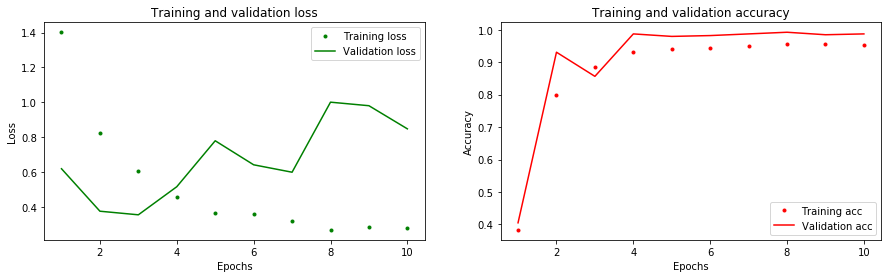

In [165]:
hist_cnn = cnn11.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['recall'] 
val_acc_values = hist_cnn['val_recall']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [164]:
cnn11.history

{'loss': [1.4018456935882568,
  0.825508713722229,
  0.6050349473953247,
  0.45505425333976746,
  0.3657848834991455,
  0.3572280704975128,
  0.3182477355003357,
  0.26860812306404114,
  0.28292644023895264,
  0.2781551480293274],
 'recall': [0.38322579860687256,
  0.800000011920929,
  0.8854193687438965,
  0.9308387041091919,
  0.9414193630218506,
  0.944516122341156,
  0.9489032030105591,
  0.9553548097610474,
  0.9548386931419373,
  0.9525161385536194],
 'val_loss': [0.6193583011627197,
  0.37583062052726746,
  0.3552126884460449,
  0.5162497162818909,
  0.7796792984008789,
  0.641943633556366,
  0.5993802547454834,
  1.000933051109314,
  0.9806433320045471,
  0.8480660915374756],
 'val_recall': [0.40512821078300476,
  0.9307692050933838,
  0.8564102649688721,
  0.9871794581413269,
  0.9794871807098389,
  0.9820512533187866,
  0.9871794581413269,
  0.9923076629638672,
  0.9846153855323792,
  0.9871794581413269]}

In [166]:
cnn12 = models.Sequential()
cnn12.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  1)))
cnn12.add(layers.MaxPooling2D((2, 2)))
cnn12.add(layers.Dropout(.5))
cnn12.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn12.add(layers.MaxPooling2D((2, 2)))
cnn12.add(layers.Dropout(.5))
cnn12.add(layers.Flatten())
cnn12.add(layers.Dense(32, activation='relu'))
cnn12.add(layers.Dropout(.5))
cnn12.add(layers.Dense(16, activation = 'relu'))
cnn12.add(layers.Dropout(.3))
cnn12.add(layers.Dense(32, activation = 'relu'))
cnn12.add(layers.Dense(1, activation='sigmoid'))

cnn12.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['AUC'])

For this last model, we changed the metric to AUC but left everything else the same. Again, it performed perfectly on the validation set but did worse on the test data. Still, very good results overall.

In [167]:
cnn13 = cnn12.fit(X_train, y_train,
               epochs=10,
               batch_size=50,
               validation_data = (X_test, y_test), 
               class_weight=weights,
               verbose=True)

Epoch 1/10
105/105 [==============================] - 201s 2s/step - loss: 1.4212 - auc: 0.5284 - val_loss: 0.6669 - val_auc: 0.7073
Epoch 2/10
105/105 [==============================] - 201s 2s/step - loss: 1.1134 - auc: 0.7845 - val_loss: 0.4305 - val_auc: 0.8837
Epoch 3/10
105/105 [==============================] - 202s 2s/step - loss: 0.6794 - auc: 0.9303 - val_loss: 0.4783 - val_auc: 0.8869
Epoch 4/10
105/105 [==============================] - 199s 2s/step - loss: 0.5784 - auc: 0.9513 - val_loss: 0.4253 - val_auc: 0.8828
Epoch 5/10
105/105 [==============================] - 205s 2s/step - loss: 0.5688 - auc: 0.9520 - val_loss: 0.6076 - val_auc: 0.8854
Epoch 6/10
105/105 [==============================] - 206s 2s/step - loss: 0.4839 - auc: 0.9644 - val_loss: 0.4597 - val_auc: 0.8902
Epoch 7/10
105/105 [==============================] - 198s 2s/step - loss: 0.4378 - auc: 0.9701 - val_loss: 0.6239 - val_auc: 0.8960
Epoch 8/10
105/105 [==============================] - 198s 2s/step - 

In [168]:
results_val = cnn12.evaluate(X_val, y_val)

1/1 [==============================] - 0s 1ms/step - loss: 0.1971 - auc: 1.0000
